## 1.无监督学习算法

无监督学习的算法适用于正常数据和异常数据都存在且没有标签的情况下，这种异常值检测也被称作为离群值检测，所谓离群点检测就是: 训练数据包含离群点,即远离其它内围点。离群点检测估计器会尝试拟合出训练数据中内围点聚集的区域, 会忽略有偏离的观测值。这类算法主要有：

    IsolationForest
    
    DBSCAN
    
    Local Outlier Factor（LOF）

**数据准备**

解释：因为是训练模型，所以这里人为的加入了标签，目的在于评价模型预测结果

**训练集**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#这里是脱敏数据，使用修改路径即可
data = pd.read_csv("E:/bladed/test26-abnormal.csv")

X = data[data.columns[:-1]]
y = data['target']

print(X.shape)
print(y.shape)
print(y.value_counts())   #1 代表正常，-1代表异常，比例9:1

(49997, 13)
(49997,)
 1    44998
-1     4999
Name: target, dtype: int64


**测试集**

In [4]:
test = pd.read_csv("E:/bladed/test26_test_13.csv")
X_test = test[test.columns[:-1]]
y_test = test['target']
print(X_test.shape)
print(y_test.shape)
print(y_test.value_counts())   #1 代表正常，-1代表异常

(701, 13)
(701,)
 1    502
-1    199
Name: target, dtype: int64


In [5]:
#数据标准化
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

### 1. IsolationForest 


#### 1.1 IsolationForest 训练

In [6]:
#IsolationForest训练拟合
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=900, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=-1, 
                     behaviour='deprecated', random_state=42, verbose=0, warm_start=False).fit(X)

In [7]:
#预测结果展示比较
IF_predict = IF.predict(X)
train_if = pd.DataFrame(IF_predict,columns=["predict"])
train_if["y"] = y
train_if

,predict,y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
49992,-1,-1
49993,-1,-1
49994,-1,-1
49995,-1,-1


**1.2 IsolationForest 训练结果评价**

|  |  |预测值 | |
|--|--|--|--|
|  |  |-1 | 1|
|  真实值 | -1 |TP（-1-1） | FN（-11）|
| | 1 | FP（1-1）|TN（11） |
　　

`classification_report`每个分类标签的精确度，召回率和 F1-score。

    精确度：`precision`，正确预测为正的，占全部预测为正的比例，
$$TP / (TP+FP)$$
    
    召回率：`recall`，正确预测为正的，占全部实际为正的比例，
$$TP / (TP+FN)$$
    
    `F1-score`：精确率和召回率的调和平均数，
$$2 * precision*recall /(precision+recall)$$
    
同时还会给出总体的微平均值，宏平均值和加权平均值。

    微平均值：micro average，所有数据结果的平均值
    
    宏平均值：macro average，所有标签结果的平均值
    
    加权平均值：weighted average，所有标签结果的加权平均值
    
在二分类场景中，正标签的召回率称为敏感度（sensitivity），负标签的召回率称为特异性（specificity）。

In [119]:
from sklearn.metrics import confusion_matrix   #混淆矩阵
from sklearn.metrics import accuracy_score     #准确率
from sklearn.metrics import precision_score    #精确率
from sklearn.metrics import recall_score       #召回率
from sklearn.metrics import f1_score           #F1-得分
from sklearn.metrics import classification_report

print("混淆矩阵：")
print(confusion_matrix(y,IF_predict))
print("标准化混淆矩阵：")
print(confusion_matrix(y,IF_predict,normalize='true'))
print("得分详细：")
print(classification_report(y,IF_predict))

混淆矩阵：
[[ 3259  1740]
 [ 5092 39906]]
标准化混淆矩阵：
[[0.65193039 0.34806961]
 [0.11316058 0.88683942]]
得分详细：
              precision    recall  f1-score   support

          -1       0.39      0.65      0.49      4999
           1       0.96      0.89      0.92     44998

    accuracy                           0.86     49997
   macro avg       0.67      0.77      0.70     49997
weighted avg       0.90      0.86      0.88     49997



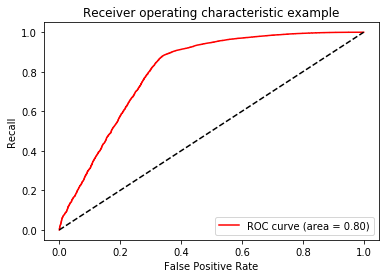

In [118]:
from sklearn.metrics import roc_curve          #ROC曲线
from sklearn.metrics import roc_auc_score      #AUC面积

area = roc_auc_score(y,IF.decision_function(X))
FPR, recall, thresholds = roc_curve(y,IF.decision_function(X))

plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**1.3 IsolationForest 测试结果评价**

|  |  |预测值 | |
|--|--|--|--|
|  |  |-1 | 1|
|  真实值 | -1 |TP（-1-1） | FN（-11）|
| | 1 | FP（1-1）|TN（11） |
　　

In [10]:
IF_test = IF.predict(X_test)    #测试预测结果
IF_decision_function = IF.decision_function(X_test)   #测试预测决策函数结果
IF_score_samples = IF.score_samples(X_test)       #测试预测样本得分

In [11]:
#形成DataFrame,便于展示
IF_tests=pd.DataFrame(IF_test,columns = ["predict"])
IF_tests["y_test"] = y_test
IF_tests["decision_function"] = IF_decision_function
IF_tests["score_samples"] = IF_score_samples
IF_tests

,predict,y_test,decision_function,score_samples
0,-1,1,-0.005467,-0.505467
1,-1,1,-0.004929,-0.504929
2,-1,1,-0.010680,-0.510680
3,-1,1,-0.025672,-0.525672
4,-1,1,-0.039898,-0.539898
...,...,...,...,...
696,-1,-1,-0.100574,-0.600574
697,-1,-1,-0.093604,-0.593604
698,-1,-1,-0.084548,-0.584548
699,-1,-1,-0.074774,-0.574774


In [120]:
#测试集评价指标结果

print("测试混淆矩阵：")
print(confusion_matrix(y_test,IF_test))
print("测试标准化混淆矩阵：")
print(confusion_matrix(y_test,IF_test,normalize='true'))
print("得分详细：")
print(classification_report(y_test,IF_test))

测试混淆矩阵：
[[176  23]
 [ 76 426]]
测试标准化混淆矩阵：
[[0.88442211 0.11557789]
 [0.15139442 0.84860558]]
得分详细：
              precision    recall  f1-score   support

          -1       0.70      0.88      0.78       199
           1       0.95      0.85      0.90       502

    accuracy                           0.86       701
   macro avg       0.82      0.87      0.84       701
weighted avg       0.88      0.86      0.86       701



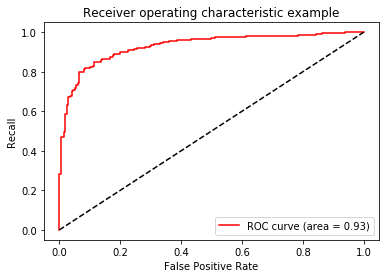

In [13]:
from sklearn.metrics import roc_curve          #ROC曲线
from sklearn.metrics import roc_auc_score      #AUC面积

area = roc_auc_score(y_test,IF.decision_function(X_test))
FPR, recall, thresholds = roc_curve(y_test,IF.decision_function(X_test))

plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 2 DBSCAN

#### 2.1 DBSCAN训练

以每个点为中心，设定邻域及邻域内需要有多少个点，如果样本点大于指定要求，则认为该点与邻域内的点属于同一类，如果小于指定值，若该点位于其它点的邻域内，则属于边界点。

设定两个参数:

    eps为领域的大小
    
    min_samples为领域内最小点的个数点。

In [105]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=0.9, min_samples=5, metric='euclidean', metric_params=None, 
            algorithm='auto', leaf_size=30, p=None, n_jobs=-1).fit(X)


In [106]:
labels = DB.labels_ # 获取类别标签，-1表示未分类

labels[labels>=0]=1 #筛选出异常值

In [107]:
#预测结果展示比较
train_DB = pd.DataFrame(labels,columns=["predict"])
train_DB["y"] = y
train_DB

,predict,y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
49992,-1,-1
49993,-1,-1
49994,-1,-1
49995,-1,-1


In [108]:
train_DB["predict"].value_counts()

 1    40005
-1     9992
Name: predict, dtype: int64

In [121]:
print("混淆矩阵：")
print(confusion_matrix(y,labels))
print("标准化混淆矩阵：")
print(confusion_matrix(y,labels,normalize='true'))
print("得分详细：")
print(classification_report(y,labels))

混淆矩阵：
[[ 3253  1746]
 [ 6739 38259]]
标准化混淆矩阵：
[[0.65073015 0.34926985]
 [0.14976221 0.85023779]]
得分详细：
              precision    recall  f1-score   support

          -1       0.33      0.65      0.43      4999
           1       0.96      0.85      0.90     44998

    accuracy                           0.83     49997
   macro avg       0.64      0.75      0.67     49997
weighted avg       0.89      0.83      0.85     49997



**2.3 DBSCAN 测试结果评价**

In [110]:
labels_test = DB.fit_predict(X_test)
labels_test[labels_test>=0]=1 #筛选出异常值

In [122]:
#测试集评价指标结果

print("测试混淆矩阵：")
print(confusion_matrix(y_test,labels_test))
print("测试标准化混淆矩阵：")
print(confusion_matrix(y_test,labels_test,normalize='true'))
print("得分详细：")
print(classification_report(y_test,labels_test))

测试混淆矩阵：
[[159  40]
 [124 378]]
测试标准化混淆矩阵：
[[0.79899497 0.20100503]
 [0.24701195 0.75298805]]
得分详细：
              precision    recall  f1-score   support

          -1       0.56      0.80      0.66       199
           1       0.90      0.75      0.82       502

    accuracy                           0.77       701
   macro avg       0.73      0.78      0.74       701
weighted avg       0.81      0.77      0.78       701



### 3 LOF

#### 3.1 LOF训练

LOF通过计算一个数值score来反映一个样本的异常程度。 这个数值的大致意思是：

    一个样本点周围的样本点所处位置的平均密度比上该样本点所在位置的密度。比值越大于1，则该点所在位置的密度越小于其周围样本所在位置的密度。
    
    
    
    
方法	|离群点检测`novelty = False`|新奇点检测`novelty = True`
--|--|--|
fit_predict|	可用	|不可用
predict	|不可用	|只能用于新数据
decision_function|	不可用	|只能用于新数据
score_samples	|用 negative_outlier_factor_	|只能用于新数据

In [131]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(n_neighbors=70, algorithm='auto', leaf_size=5, metric='minkowski',p=2, 
                         metric_params=None, contamination='auto', novelty=False, n_jobs=-1).fit(X)
LOF_predict = LOF.fit_predict(X)

In [132]:
print("混淆矩阵：")
print(confusion_matrix(y,LOF_predict))
print("标准化混淆矩阵：")
print(confusion_matrix(y,LOF_predict,normalize='true'))
print("得分详细：")
print(classification_report(y,LOF_predict))

混淆矩阵：
[[   13  4986]
 [    3 44995]]
标准化混淆矩阵：
[[2.60052010e-03 9.97399480e-01]
 [6.66696298e-05 9.99933330e-01]]
得分详细：
              precision    recall  f1-score   support

          -1       0.81      0.00      0.01      4999
           1       0.90      1.00      0.95     44998

    accuracy                           0.90     49997
   macro avg       0.86      0.50      0.48     49997
weighted avg       0.89      0.90      0.85     49997



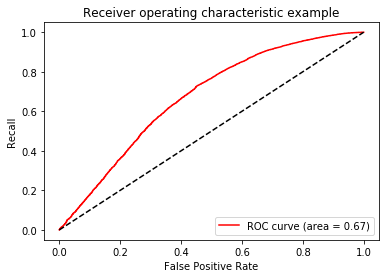

In [133]:
area = roc_auc_score(y,LOF.negative_outlier_factor_)
FPR, recall, thresholds = roc_curve(y,LOF.negative_outlier_factor_)

plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### 3.2 LOF测试

In [135]:
LOF_test = LOF.fit_predict(X_test)

In [136]:
print("混淆矩阵：")
print(confusion_matrix(y_test,LOF_test))
print("标准化混淆矩阵：")
print(confusion_matrix(y_test,LOF_test,normalize='true'))
print("得分详细：")
print(classification_report(y_test,LOF_test))

混淆矩阵：
[[  2 197]
 [  0 502]]
标准化混淆矩阵：
[[0.01005025 0.98994975]
 [0.         1.        ]]
得分详细：
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       199
           1       0.72      1.00      0.84       502

    accuracy                           0.72       701
   macro avg       0.86      0.51      0.43       701
weighted avg       0.80      0.72      0.60       701



<center><h1>总结</h1></center>

无监督学习的算法适用于正常数据和异常数据都存在且没有标签的情况下，这种异常值检测也被称作为离群值检测，所谓离群点检测就是: 训练数据包含离群点,即远离其它内围点。离群点检测估计器会尝试拟合出训练数据中内围点聚集的区域, 会忽略有偏离的观测值。这类算法主要有：

    IsolationForest（最优）
    
    DBSCAN（难调参）
    
    Local Outlier Factor（LOF）（效果糟糕）
    
    